In [1]:
# -*- coding: utf-8 -*-
"""
2018-06-28,29

Blinker analysis: PL intensity versus laser power
PL intensity versus laser power, QE 4-22-2018.11,00am

@author: Viva Horowitz
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
import numpy as np
sns.set(style='ticks')
sns.set_context('poster')

%pylab inline

# ** set for each dataset
datadate = '2018-06-01'
datafolder = r'O:\User\Viva\data\2018-06-01_blinking-statistics\4-22-2018.11,00am'
analysisfolder = r'C:\Users\Viva\Documents\analysis\blinker_analysis\power_dependence,QE4-22-2018.11,00am'
filenames = ['4-22-2018.11,00am, 03, ND2,4.txt',
             '4-22-2018.11,00am, 04, ND2,3.txt',
             '4-22-2018.11,00am, 05, ND2,2.txt',
             '4-22-2018.11,00am, 06, ND2,0.txt',
             '4-22-2018.11,00am, 07, ND1,6.txt',
             '4-22-2018.11,00am, 08, ND1,5.txt',
             '4-22-2018.11,00am, 11, ND1,4.txt',
             '4-22-2018.11,00am, 12, ND1,3.txt',
             '4-22-2018.11,00am, 13, ND1,2.txt',
             '4-22-2018.11,00am, 14, ND1,0.txt']   

dataname = 'QE 4-22-2018.11,00am, data taken 2018-06-01'

NDlist = [2.4, 2.3, 2.2, 2.0, 1.6, 1.5, 1.4, 1.3, 1.2, 1.0]

print(np.__version__)
print(sns.__version__)
print(pd.__version__)
print(mpl.__version__)

Populating the interactive namespace from numpy and matplotlib
1.10.4
0.8.0
0.20.3
2.1.0


In [2]:
os.chdir(r'O:\User\Viva')
filterwheel = pd.read_csv('Josh_filter_wheel.csv')

In [3]:
# Does not display all digits but they are stored.
filterwheel.head(1)

,ND,Power (W)
0,1.0,0.000995


In [4]:
## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

# http://code.activestate.com/recipes/66472-frange-a-range-function-with-float-increments/
# could also use linspace
def frange(start, end=None, inc=None):
    "A range function, that does accept float increments..."

    if end == None:
        end = start + 0.0
        start = 0.0

    if inc == None:
        inc = 1.0

    L = []
    while 1:
        next = start + len(L) * inc
        if inc > 0 and next >= end:
            break
        elif inc < 0 and next <= end:
            break
        L.append(next)
        
    return L

def manualnorm(histdata, binwidth):
    return (1/(histdata.sum()*binwidth))*histdata



   Time (s) 2.4   2.4
0         0.008  5.75
1         0.012  6.25
2         0.016  5.50
3         0.020  5.75
4         0.024  6.25


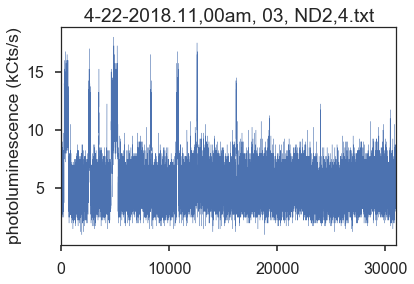

   Time (s) 2.3   2.3
0        17.252  6.50
1        17.256  9.50
2        17.260  5.00
3        17.264  6.50
4        17.268  5.25


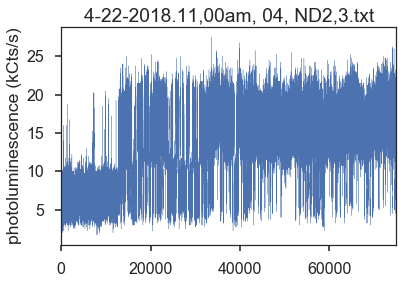

   Time (s) 2.2    2.2
0        58.088  22.75
1        58.092  21.75
2        58.096  19.25
3        58.100  21.50
4        58.104  15.50


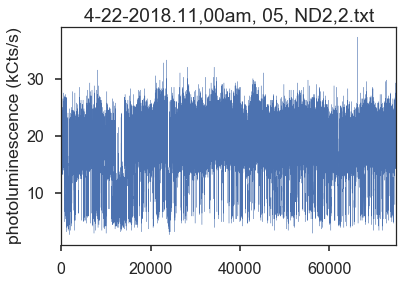

   Time (s) 2.0    2.0
0        38.860  23.50
1        38.864  22.50
2        38.868  30.50
3        38.872  24.50
4        38.876  30.75


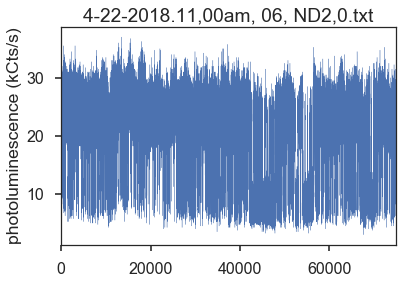

   Time (s) 1.6    1.6
0         0.008  70.50
1         0.012  66.50
2         0.016  66.75
3         0.020  73.50
4         0.024  74.50


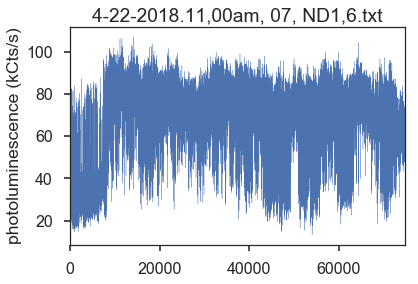

   Time (s) 1.5    1.5
0         0.008  88.00
1         0.012  88.75
2         0.016  76.50
3         0.020  81.75
4         0.024  79.50


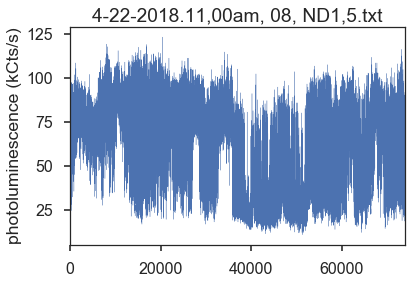

   Time (s) 1.4    1.4
0         0.002  118.0
1         0.003  106.0
2         0.004   97.0
3         0.005   89.0
4         0.006  104.0


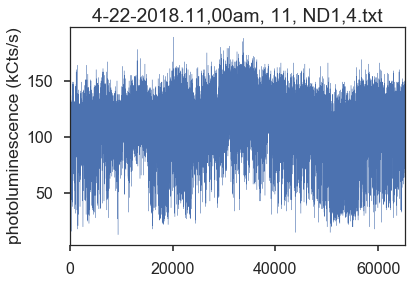

   Time (s) 1.3    1.3
0         4.602  150.0
1         4.603  136.0
2         4.604  137.0
3         4.605  124.0
4         4.606  131.0


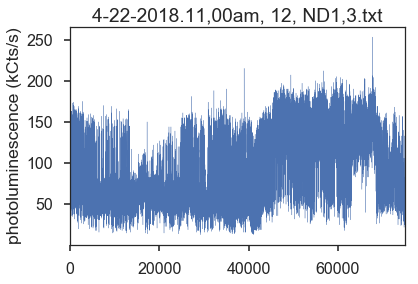

   Time (s) 1.2   1.2
0         0.002  74.0
1         0.003  80.0
2         0.004  52.0
3         0.005  86.0
4         0.006  80.0


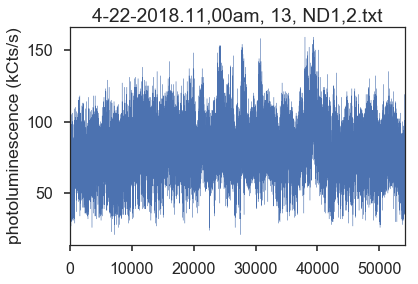

   Time (s) 1.0    1.0
0         0.002   97.0
1         0.003  132.0
2         0.004   95.0
3         0.005  112.0
4         0.006   79.0


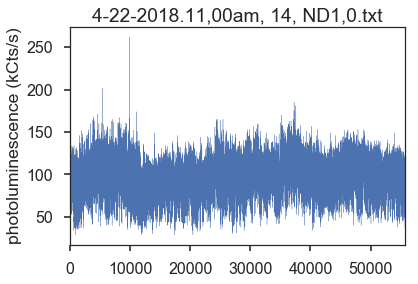

today: 2018-06-29


'C:\\Users\\Viva\\Documents\\analysis\\blinker_analysis\\power_dependence,QE4-22-2018.11,00am\\taken-2018-06-01'

In [5]:
os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kCts/s)'

for i in range(len(filenames)):
    data = pd.read_csv(filenames[i],
                       skiprows=1,
                       header=None,
                       sep='\t',
                       names=['Time (s) ' + str(NDlist[i]),str(NDlist[i])],
                       usecols=[0,1])
    #data = data.set_index(tname)
    print(data.head())
    #rebincount = 0

    #plt.scatter(x=data['Time (s) ' + str(NDlist[i])], y=str(NDlist[i]),linewidth=0.3)
    data[str(NDlist[i])].plot(linewidth=0.3)
    plt.ylabel('photoluminescence (kCts/s)')
    #plt.xlabel('Time(s)')
    plt.title(filenames[i])
    plt.show()
    
    if i > 0:
        alldata = pd.concat([alldata,data], axis=1)
    else:
        alldata = data        
        
#filename = filename.replace('\\','-')
#origfilename = filename
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
os.getcwd()

In [6]:
alldata.tail()

,Time (s) 2.4,2.4,Time (s) 2.3,2.3,Time (s) 2.2,2.2,Time (s) 2.0,2.0,Time (s) 1.6,1.6,Time (s) 1.5,1.5,Time (s) 1.4,1.4,Time (s) 1.3,1.3,Time (s) 1.2,1.2,Time (s) 1.0,1.0
74994,NaN,NaN,317.228,19.75,358.064,20.50,338.836,25.75,NaN,NaN,NaN,NaN,NaN,NaN,79.596,28.0,NaN,NaN,NaN,NaN
74995,NaN,NaN,317.232,13.00,358.068,20.00,338.840,20.00,NaN,NaN,NaN,NaN,NaN,NaN,79.597,28.0,NaN,NaN,NaN,NaN
74996,NaN,NaN,317.236,20.25,358.072,14.75,338.844,22.00,NaN,NaN,NaN,NaN,NaN,NaN,79.598,30.0,NaN,NaN,NaN,NaN
74997,NaN,NaN,317.240,11.75,358.076,19.75,338.848,21.50,NaN,NaN,NaN,NaN,NaN,NaN,79.599,35.0,NaN,NaN,NaN,NaN
74998,NaN,NaN,317.244,14.00,358.080,18.50,338.852,23.75,NaN,NaN,NaN,NaN,NaN,NaN,79.600,25.0,NaN,NaN,NaN,NaN


In [7]:
strNDlist = []
for ND in NDlist:
    strNDlist.append(str(ND))
data = alldata[strNDlist]
data.head()

,2.4,2.3,2.2,2.0,1.6,1.5,1.4,1.3,1.2,1.0
0,5.75,6.50,22.75,23.50,70.50,88.00,118.0,150.0,74.0,97.0
1,6.25,9.50,21.75,22.50,66.50,88.75,106.0,136.0,80.0,132.0
2,5.50,5.00,19.25,30.50,66.75,76.50,97.0,137.0,52.0,95.0
3,5.75,6.50,21.50,24.50,73.50,81.75,89.0,124.0,86.0,112.0
4,6.25,5.25,15.50,30.75,74.50,79.50,104.0,131.0,80.0,79.0


In [8]:
strNDlist

['2.4', '2.3', '2.2', '2.0', '1.6', '1.5', '1.4', '1.3', '1.2', '1.0']

In [9]:
print max(data.max())
print min(data.min())

262.0
1.0


histdata initialized


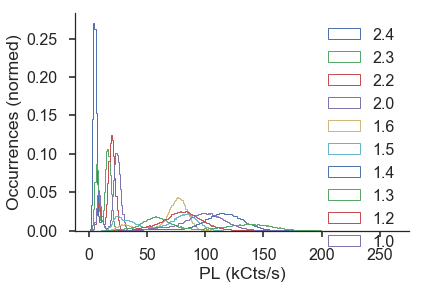

In [10]:
stepsize = 1
# adding a stepsize to the max is a workaround to a bug
binsequence= frange(min(data.min()),max(data.max())+stepsize,stepsize)

try:
    del histdata
except NameError:
    pass
#histdata=pd.DataFrame(columns=['ND', PLname, "Occurrences"])

histdict = []
for i in range(len(strNDlist)):
    plt.hist(data[strNDlist[i]], bins=binsequence,  histtype='step', linewidth=1, label=strNDlist[i], normed=True)
    newhistdata, toss = histc(data[strNDlist[i]], bins=np.asarray(binsequence))
    NDlisttemp = [NDlist[i]] * len(binsequence)
    ## Norm the newhistdata
    #   adding a stepsize to the max was a workaround to a bug
    #   now we remove that last bin, which should have been empty (but it's so buggy it wasn't empty)
    newhistdatanormed = manualnorm(newhistdata[:-1], stepsize)
    
    try:
        # append histogram to dataframe histdata

        histdata = histdata.append(pd.DataFrame(transpose([NDlisttemp[:-1], binsequence[:-1],newhistdatanormed.tolist()])))
#        print "appended"
    except NameError:
        histdata = pd.DataFrame(transpose([NDlisttemp[:-1], binsequence[:-1],newhistdatanormed.tolist()]))
        print "histdata initialized"
histdata = histdata.rename(index=str, columns={0: 'ND', 1: PLname, 2:"Probability"})           
tabledata = histdata.pivot("ND", PLname, "Probability")

# In terms of laser intensity instead of optical density
powertabledata = tabledata.join(filterwheel.set_index('ND')).set_index('Power (W)')

#sns.distplot(data[strNDlist[9]], bins=numbins, kde=True, rug=False, hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('PL (kCts/s)')
plt.ylabel('Occurrences (normed)')
#ax = plt.gca()
#ax.set_yscale('symlog', linthreshy=1)
#ax.set_xscale('log')
sns.despine()
plt.legend()
plt.show()


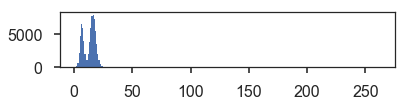

In [83]:
hist(data[strNDlist[1]], bins=binsequence);

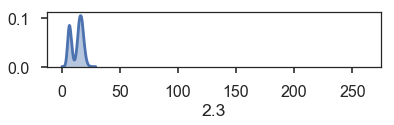

In [62]:
## I want to extract the peaks of these data

plt.figure()
output = sns.distplot(data[strNDlist[1]],bins=binsequence).get_lines()[0].get_data()

In [ ]:
# %load r'C:\Users\Viva\Documents\detect_peaks.py'
C:\Users\Viva\Documents\detect_peaks.py

In [96]:
## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
from detect_peaks import detect_peaks

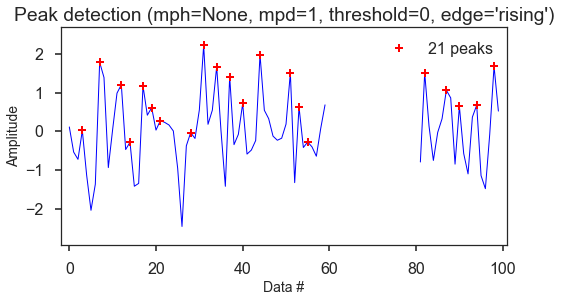

[ 3  7 12 14 17 19 21 28 31 34 37 40 44 51 53 55 82 87 90 94 98]


In [97]:
x = np.random.randn(100)
x[60:81] = np.nan
# detect all peaks and plot data
ind = detect_peaks(x, show=True)
print(ind)

ImportError: No module named detect_peaks

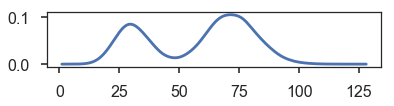

In [88]:
plt.plot(binsequence[:len(output[1])],output[1]);
#plot(output[1])



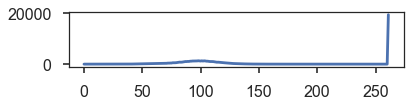

In [85]:
# The bug!
plot(newhistdata);

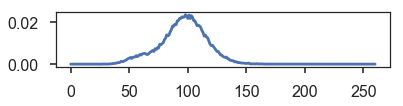

In [86]:
# Dealt with the bug!
plot(newhistdatanormed);

In [13]:
histdata.head()

,ND,PL Intensity (kCts/s),Probability
0,2.4,1.0,0.002258
1,2.4,2.0,0.032935
2,2.4,3.0,0.145032
3,2.4,4.0,0.269710
4,2.4,5.0,0.262871


In [14]:
NDlist

[2.4, 2.3, 2.2, 2.0, 1.6, 1.5, 1.4, 1.3, 1.2, 1.0]

In [15]:
powlist = []
for ND in NDlist:
    powlist.append(filterwheel.loc[filterwheel['ND']==ND]['Power (W)'].values[0]) 

powlist

[2.7399999999999995e-05,
 3.8299999999999996e-05,
 4.7899999999999999e-05,
 7.0599999999999995e-05,
 0.00022499999999999999,
 0.00030600000000000001,
 0.000377,
 0.00054800000000000009,
 0.00064000000000000005,
 0.00099500000000000001]

In [16]:
#filterwheel.set_index('ND')

# previously made NDlistwrap manually
"""
NDlistwrap = [2.45, 2.35, 2.25, (2.2+2.0)/2, (2.0+1.6)/2, 1.55, 1.45, 1.35, 1.25, (1.2+1.0)/2, 1.0-0.05]

NDlistwrap[::-1]
"""

'\nNDlistwrap = [2.45, 2.35, 2.25, (2.2+2.0)/2, (2.0+1.6)/2, 1.55, 1.45, 1.35, 1.25, (1.2+1.0)/2, 1.0-0.05]\n\nNDlistwrap[::-1]\n'

In [17]:
# create a listwrap that wraps around the list 
# This is what I need for pcolormesh.
def listwrap(currentlist):
    listwrap = [0] * (len(currentlist)+1)
    for i in range(len(currentlist)):
        try:
            listwrap[i+1] = ((currentlist[i]+currentlist[i+1])/2)
        except IndexError:
            pass
    topstep = listwrap[2]-listwrap[1]
    listwrap[0]=listwrap[1]-topstep
    botstep = listwrap[-2]-listwrap[-3]
    listwrap[-1]=listwrap[-2]+botstep
    return listwrap

In [18]:
NDlistwrap = listwrap(NDlist)
NDlistwrap[::-1]

[0.9500000000000002,
 1.1,
 1.25,
 1.35,
 1.45,
 1.55,
 1.8,
 2.1,
 2.25,
 2.3499999999999996,
 2.4499999999999993]

In [19]:
tabledata

PL Intensity (kCts/s),1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,261.0
ND,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.000000,0.000000,0.000227,0.002560,0.011587,0.029307,0.046827,0.052094,0.046907,0.031960,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.2,0.000000,0.000027,0.000480,0.002187,0.009013,0.020107,0.031040,0.036214,0.030974,0.020774,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.3,0.000027,0.000720,0.006573,0.027907,0.063588,0.087001,0.078334,0.052627,0.025987,0.013960,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0,0.5,u'ND')

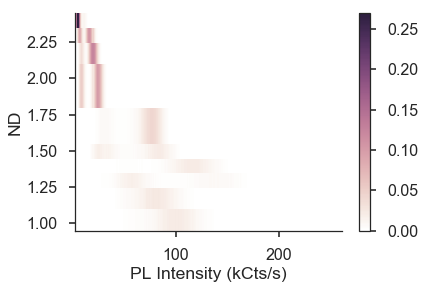

In [20]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

plt.pcolormesh(binsequence,NDlistwrap[::-1],  tabledata, cmap=cmap)
sns.despine()
colorbar()


plt.xlabel(PLname)
plt.ylabel('ND')

In [21]:
powlist

[2.7399999999999995e-05,
 3.8299999999999996e-05,
 4.7899999999999999e-05,
 7.0599999999999995e-05,
 0.00022499999999999999,
 0.00030600000000000001,
 0.000377,
 0.00054800000000000009,
 0.00064000000000000005,
 0.00099500000000000001]

In [22]:
powlistwrap = listwrap(powlist)
powlistwrap

[2.26e-05,
 3.2849999999999999e-05,
 4.3099999999999997e-05,
 5.9249999999999997e-05,
 0.00014779999999999999,
 0.0002655,
 0.00034150000000000001,
 0.00046250000000000002,
 0.00059400000000000013,
 0.00081750000000000008,
 0.001041]

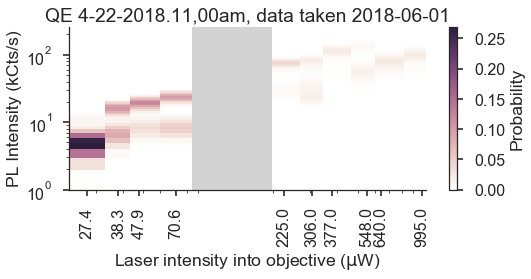

In [46]:
#cmap = sns.cubehelix_palette(n_colors = 1, start=0, rot=1, light=1, as_cmap=True)
cmap = sns.cubehelix_palette( light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

figure(figsize=(8,3))
plt.pcolormesh(powlistwrap[::-1],  binsequence, transpose(powertabledata), cmap=cmap)
sns.despine()
cbar = colorbar(drawedges=False)
cbar.set_label('Probability')
#ylim(ymin=0)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


xticks(powlist, [pow*1000*1000 for pow in powlist],rotation='vertical')
#xticks(powlist, [pow for pow in powlist],rotation='vertical')

plt.ylabel(PLname)
plt.xlabel('Laser intensity into objective ($\mathrm{\mu}$W)')
#plt.xlabel('Laser intensity into objective (W)')
title(dataname)

plt.axvline(x=1.3e-4, linewidth=80, color='lightgrey')


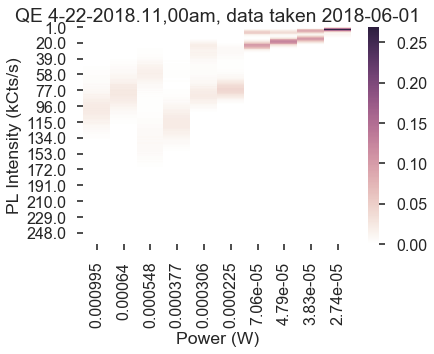

In [24]:
sns.heatmap(transpose(powertabledata), cmap = cmap)
ylabel(PLname)
title(dataname)

## decrease number of ticks on x axis.
ax = plt.gca()
#ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
#ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

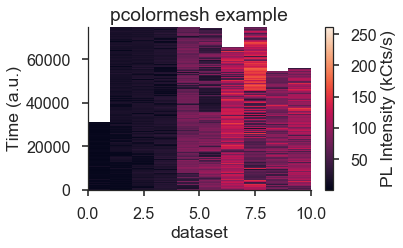

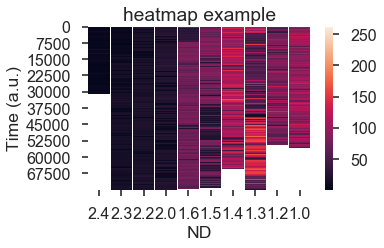

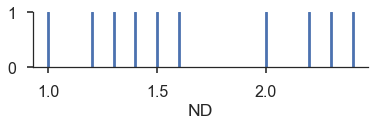

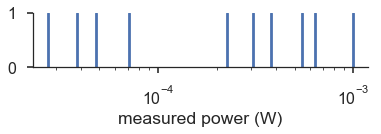

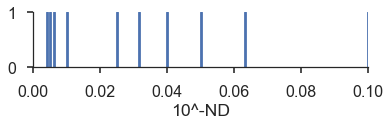

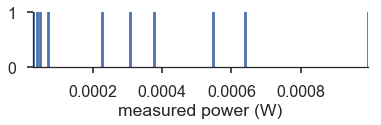

In [25]:
## This cell doesn't have to be run. Just some thoughts about the data system.

figure(figsize(5,3))
plt.pcolormesh(data)
sns.despine()

cbar =colorbar()
cbar.set_label(PLname)
title('pcolormesh example')
ylabel('Time (a.u.)')
xlabel('dataset')
plt.show()

figure()
sns.heatmap(data, linewidths=0)
title('heatmap example')
ylabel('Time (a.u.)')
xlabel('ND')


# https://stackoverflow.com/questions/49020709/seaborn-heatmap-with-numerical-axes
# You cannot "convince" heatmap not to produce a categorical plot. 
# Best use another image plot, which uses numerical axes. For example, use a pcolormesh plot. 
# The assumption is of course that the columns and rows are equally spread. 


## Some thoughts about figure spacing
plt.figure(figsize(6,1))
for ND in NDlist:
    plt.axvline(x=ND)
sns.despine()
xlabel('ND')
    
plt.figure()
for thispower in powlist:
   # print thispower
    plt.axvline(x=thispower)
#plt.xlim(xmin=min(powlist), xmax = max(powlist))
sns.despine()
ax = plt.gca()
ax.set_xscale('log')
xlabel('measured power (W)' )    
    
plt.figure()
for ND in NDlist:
    plt.axvline(x=10**-ND)
plt.xlim(xmax=10**-min(NDlist))   
sns.despine()
xlabel('10^-ND')

plt.figure()
for thispower in powlist:
  #  print thispower
    plt.axvline(x=thispower)
plt.xlim(xmin=min(powlist), xmax = max(powlist))
sns.despine()
xlabel('measured power (W)' )




plt.show()